<a href="https://colab.research.google.com/github/SorrowAddict/SK-FLY-AI/blob/main/AI_Learning/Week-03_DACON_AI_Training/2401013_%ED%83%80%EC%9D%B4%ED%83%80%EB%8B%89_%ED%94%BC%EC%B3%90_%EC%A4%91%EC%9A%94%EB%8F%84_%EA%B8%B0%EB%B0%98_Feature_Selection_%26_LGBM_K_Fold_%EC%95%99%EC%83%81%EB%B8%94(%EC%A0%95%EB%8F%84%EC%98%81).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab 한글

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

## Import & Data Load

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [ ]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [ ]:
test.isnull().sum()

ARI_CO                    0
ARI_PO                    0
SHIP_TYPE_CATEGORY        0
DIST                      0
ATA                       0
ID                        0
BREADTH                   0
BUILT                     0
DEADWEIGHT                0
DEPTH                     0
DRAUGHT                   0
GT                        0
LENGTH                    0
SHIPMANAGER               0
FLAG                      0
U_WIND                91725
V_WIND                91725
AIR_TEMPERATURE       92246
BN                    91725
ATA_LT                    0
PORT_SIZE                 0
dtype: int64

In [ ]:
# 주어진 변수들에 대한 데이터프레임 생성
subset_train = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]

# 박스플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(data=subset_train)
plt.title('각 변수의 박스플롯')
plt.show()

In [ ]:
# 주어진 변수들에 대한 데이터프레임 생성
subset_train = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]

# 결측치 중간값으로 대체
subset_train_filled = subset_train.fillna(subset_train.median())

# 박스플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(data=subset_train_filled)
plt.title('결측치 대체 후 각 변수의 박스플롯')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


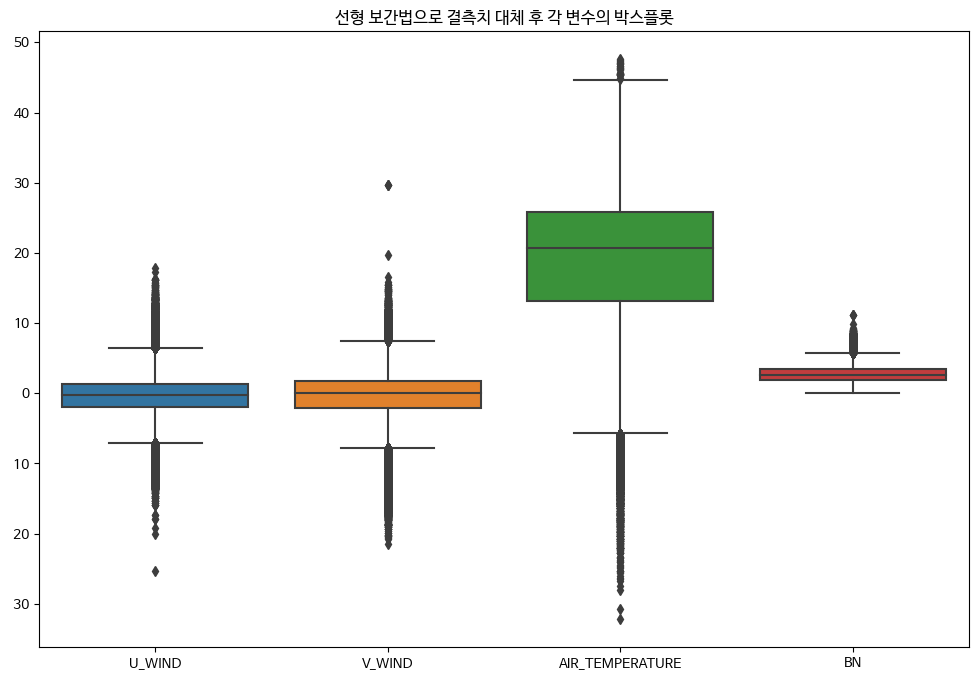

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 주어진 변수들에 대한 데이터프레임 생성
subset_train = train[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
subset_test = test[['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]

# 선형 보간법을 사용하여 결측치 대체
subset_train_interpolated = subset_train.interpolate(method='linear')
subset_test_interpolated = subset_test.interpolate(method='linear')

# 박스플롯 생성
plt.figure(figsize=(12, 8))
sns.boxplot(data=subset_train_interpolated)
plt.title('선형 보간법으로 결측치 대체 후 각 변수의 박스플롯')
plt.show()


In [ ]:
import pandas as pd

# 선형 보간법으로 결측치 처리 함수
def linear_interpolation(train):
    numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns
    train[numeric_columns] = train[numeric_columns].interpolate(method='linear', axis=0)
    return train

# 선형 보간법으로 결측치 처리 함수
def linear_interpolation(test):
    numeric_columns = test.select_dtypes(include=['float64', 'int64']).columns
    test[numeric_columns] = test[numeric_columns].interpolate(method='linear', axis=0)
    return test

# # 주어진 데이터프레임에 대해 선형 보간 수행
# train_interpolated = linear_interpolation(train)
# test_interpolated = linear_interpolation(test)

# 주어진 데이터프레임에 대해 선형 보간 수행
train = linear_interpolation(train)
test = linear_interpolation(test)

# 결과 확인
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391939 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391939 non-null  float64
 10  DRAUGHT             391939 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391939 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              391936 non-nul

<ipython-input-11-74f7d25577fb>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


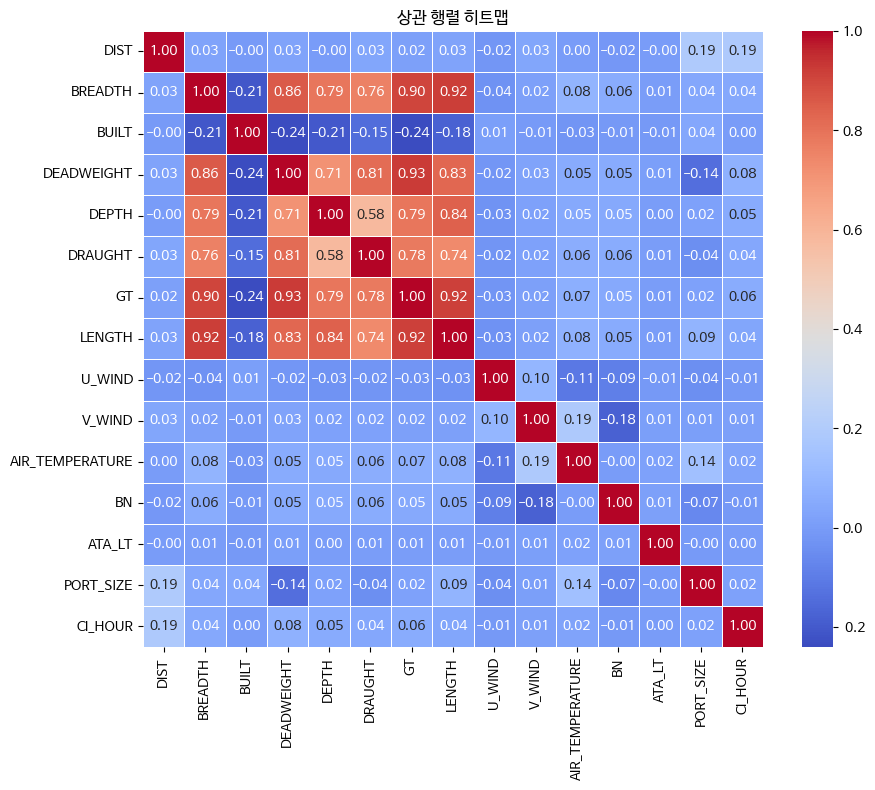

상관 계수:
                     DIST   BREADTH     BUILT  DEADWEIGHT     DEPTH   DRAUGHT  \
DIST             1.000000  0.025354 -0.004939    0.025493 -0.001034  0.031942   
BREADTH          0.025354  1.000000 -0.209508    0.857122  0.790476  0.761321   
BUILT           -0.004939 -0.209508  1.000000   -0.240297 -0.205489 -0.146959   
DEADWEIGHT       0.025493  0.857122 -0.240297    1.000000  0.712966  0.813401   
DEPTH           -0.001034  0.790476 -0.205489    0.712966  1.000000  0.581056   
DRAUGHT          0.031942  0.761321 -0.146959    0.813401  0.581056  1.000000   
GT               0.015964  0.903979 -0.238181    0.925143  0.787592  0.779027   
LENGTH           0.025215  0.920652 -0.180418    0.826763  0.842638  0.737605   
U_WIND          -0.020633 -0.035476  0.008773   -0.018790 -0.027668 -0.024371   
V_WIND           0.034594  0.015514 -0.006563    0.025618  0.020395  0.017033   
AIR_TEMPERATURE  0.000604  0.084441 -0.025031    0.054847  0.048300  0.061610   
BN              -0.01

In [ ]:
import seaborn as sns

# 상관 행렬 계산
correlation_matrix = train.corr()

# 시각화를 위한 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('상관 행렬 히트맵')
plt.show()

# 상관 계수 출력
print("상관 계수:")
print(correlation_matrix)

## Data Pre-processing

In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 61.940835


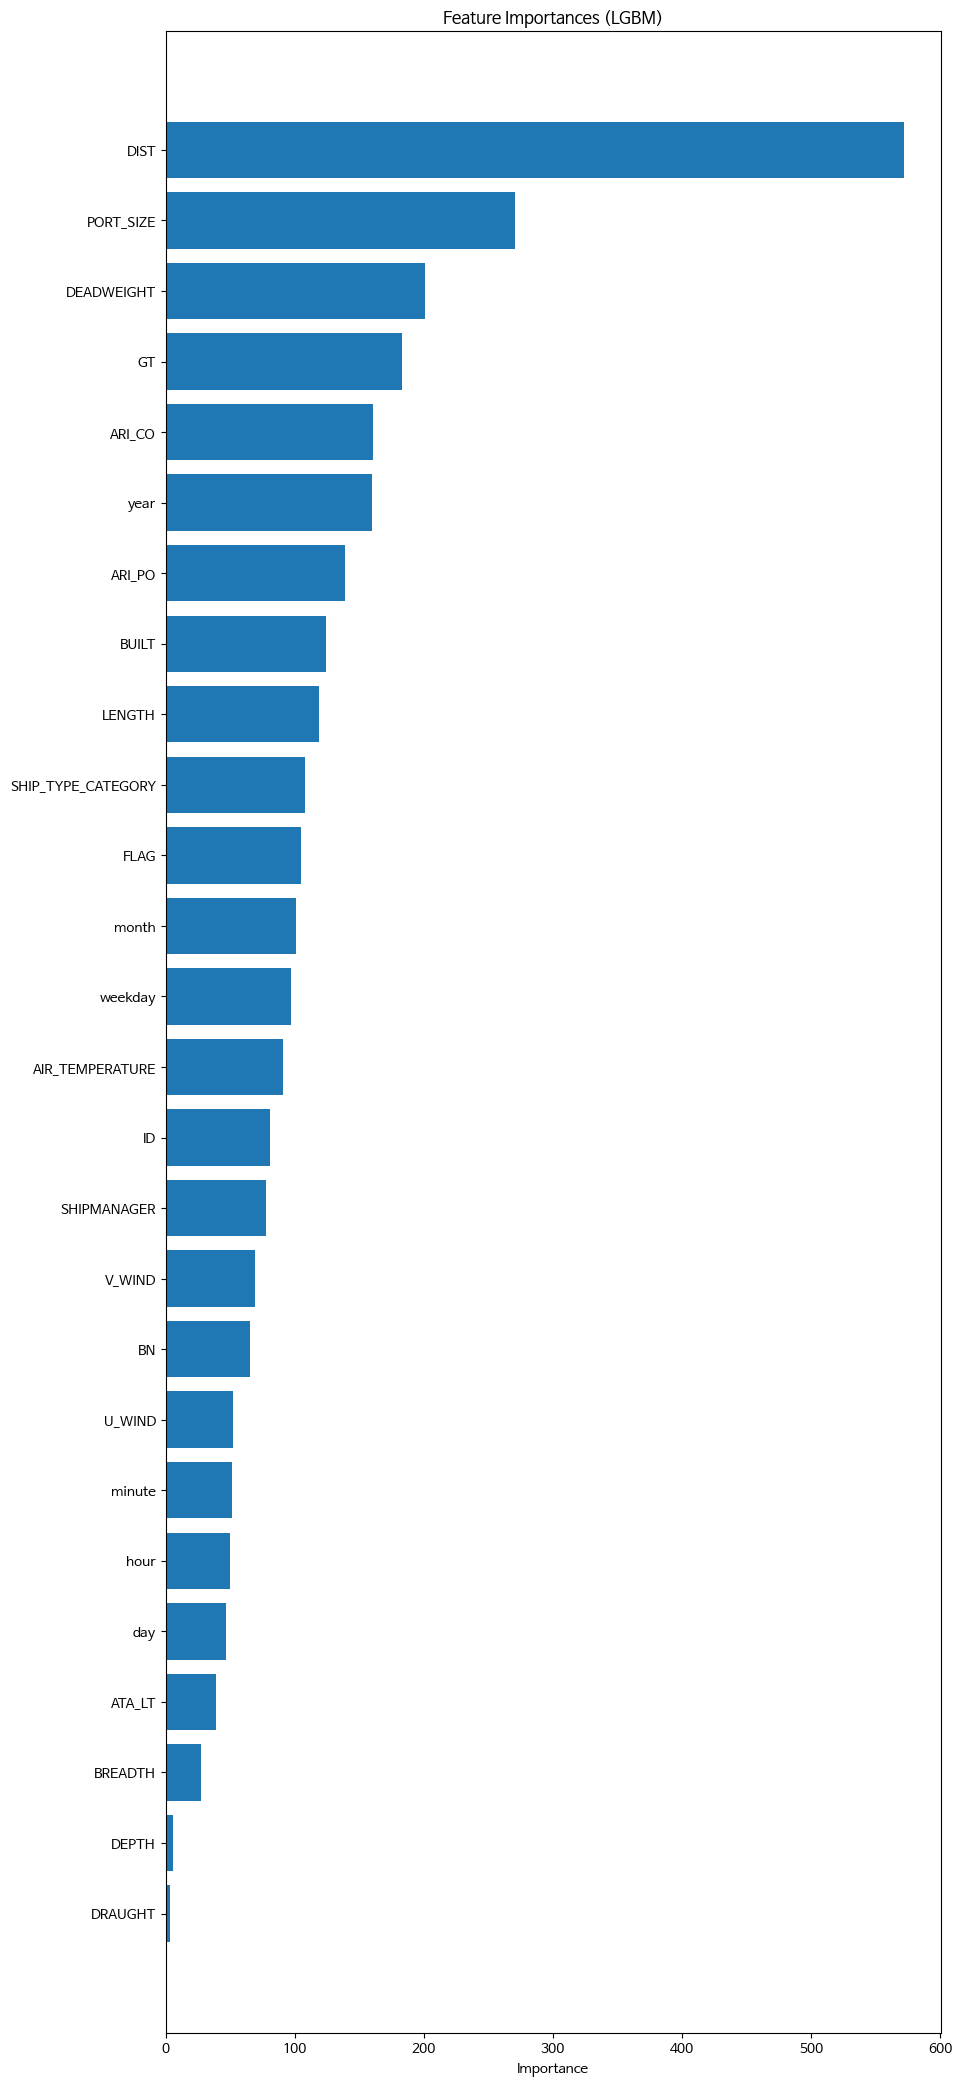

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

## 특성 중요도로부터 Feature Selection

In [ ]:
threshold = 85 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


Processing folds:  20%|██        | 1/5 [00:03<00:14,  3.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 61.815772


Processing folds:  40%|████      | 2/5 [00:07<00:12,  4.02s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 61.753606


Processing folds:  60%|██████    | 3/5 [00:11<00:07,  3.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 61.959403


Processing folds:  80%|████████  | 4/5 [00:14<00:03,  3.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 313552, number of used features: 14
[LightGBM] [Info] Start training from score 62.017911


Processing folds: 100%|██████████| 5/5 [00:19<00:00,  3.92s/it]

Validation : MAE scores for each fold: [55.04357733186468, 56.41011458666994, 56.03476718013581, 55.52734851841798, 55.45245182655421]
Validation : MAE: 55.693651888728525


## OPTUNA를 사용한 TUNING

In [ ]:
# !pip install optuna

### Optuna 최적의 파라미터 설정을 불러와서 예측

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Optuna에서 얻은 최적의 하이퍼파라미터 설정
optimal_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'subsample': 0.5241920153258646,
    'colsample_bytree': 0.982290706487749,
    'num_leaves': 980,
    'learning_rate': 0.03193930780797749,
    'n_estimators': 183,
    'reg_alpha': 0.050280225503389786,
    'reg_lambda': 0.979059995323867,
    'min_child_samples': 9,
    'n_jobs': -1,  # LGBMRegressor에 추가된 파라미터
}

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2, random_state=42)

# 모델 생성 및 훈련
model = lgb.LGBMRegressor(**optimal_params)
model.fit(X_train, y_train)

# Validation set에 대한 예측 수행
val_pred = model.predict(X_val)

# Validation set에 대한 MAE 계산
val_mae = mean_absolute_error(y_val, val_pred)

# 결과 출력
print("Validation : MAE:", val_mae)

# 최적의 모델로 test 데이터에 대한 예측 수행
final_predictions_optuna = model.predict(X_test_reduced)
final_predictions_optuna = np.where(final_predictions_optuna < 0, 0, final_predictions_optuna)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481
Validation : MAE: 50.65850267155881


# Submit

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions_optuna
submit.to_csv('./baseline_submit.csv', index=False)

### Optuna 최적의 파라미터 15회 후 예측

In [ ]:
# import optuna
# from sklearn.model_selection import train_test_split

# def objective(trial, X, y):
#     params = {
#         'objective': 'regression',
#         'metric': 'mae',
#         'boosting_type': 'gbdt',
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     model = lgb.LGBMRegressor(**params)
#     model.fit(X_train, y_train)

#     val_pred = model.predict(X_val)
#     mae = mean_absolute_error(y_val, val_pred)

#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(lambda trial: objective(trial, X_train_reduced, y_train), n_trials=15)

# best_params = study.best_params
# best_params['objective'] = 'regression'
# best_params['metric'] = 'mae'
# best_params['boosting_type'] = 'gbdt'
# best_params['n_jobs'] = -1

# # 최적의 하이퍼파라미터로 모델 재학습
# best_model = lgb.LGBMRegressor(**best_params)
# best_model.fit(X_train_reduced, y_train)

# # 최적의 모델로 test 데이터에 대한 예측 수행
# final_predictions_optuna = best_model.predict(X_test_reduced)
# final_predictions_optuna = np.where(final_predictions_optuna < 0, 0, final_predictions_optuna)

# # 결과 출력
# print("Optuna - Best MAE:", study.best_value)
# print("Optuna - Best Parameters:", study.best_params)


[I 2024-01-03 05:56:16,722] A new study created in memory with name: no-name-698a3133-156f-4ed2-85fa-440e9a532214


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:56:40,903] Trial 0 finished with value: 72.5652397869775 and parameters: {'subsample': 0.9619127950698656, 'colsample_bytree': 0.8510064097471968, 'num_leaves': 149, 'learning_rate': 0.0011928389998486077, 'n_estimators': 253, 'reg_alpha': 0.5820602235596074, 'reg_lambda': 0.20320497519982983, 'min_child_samples': 41}. Best is trial 0 with value: 72.5652397869775.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:56:59,222] Trial 1 finished with value: 55.676306205857614 and parameters: {'subsample': 0.7528644285782621, 'colsample_bytree': 0.6326606405558598, 'num_leaves': 516, 'learning_rate': 0.008030230087302585, 'n_estimators': 295, 'reg_alpha': 0.2907469449299982, 'reg_lambda': 0.6844210243397759, 'min_child_samples': 32}. Best is trial 1 with value: 55.676306205857614.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:57:33,832] Trial 2 finished with value: 56.63063748788807 and parameters: {'subsample': 0.6942337142089159, 'colsample_bytree': 0.8880420201793471, 'num_leaves': 996, 'learning_rate': 0.09619537098173239, 'n_estimators': 351, 'reg_alpha': 0.5228046337358803, 'reg_lambda': 0.3727751972170156, 'min_child_samples': 50}. Best is trial 1 with value: 55.676306205857614.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:57:38,596] Trial 3 finished with value: 57.93325616005983 and parameters: {'subsample': 0.8602991398730413, 'colsample_bytree': 0.7134730451030442, 'num_leaves': 646, 'learning_rate': 0.022910100446271446, 'n_estimators': 67, 'reg_alpha': 0.7800755546215186, 'reg_lambda': 0.981676844384137, 'min_child_samples': 56}. Best is trial 1 with value: 55.676306205857614.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:57:50,580] Trial 4 finished with value: 53.67475937592734 and parameters: {'subsample': 0.7577690755796873, 'colsample_bytree': 0.6525863984223148, 'num_leaves': 217, 'learning_rate': 0.05706423229855976, 'n_estimators': 398, 'reg_alpha': 0.8832565690272277, 'reg_lambda': 0.42094512849565735, 'min_child_samples': 17}. Best is trial 4 with value: 53.67475937592734.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:58:05,187] Trial 5 finished with value: 55.20120700614203 and parameters: {'subsample': 0.9836875966306248, 'colsample_bytree': 0.5413549796565373, 'num_leaves': 217, 'learning_rate': 0.08836413964905049, 'n_estimators': 412, 'reg_alpha': 0.7846756682896956, 'reg_lambda': 0.2723353292018911, 'min_child_samples': 83}. Best is trial 4 with value: 53.67475937592734.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:58:16,024] Trial 6 finished with value: 53.8209277938235 and parameters: {'subsample': 0.5062444305461208, 'colsample_bytree': 0.7346022532020666, 'num_leaves': 228, 'learning_rate': 0.08865290490283576, 'n_estimators': 326, 'reg_alpha': 0.8327587829607294, 'reg_lambda': 0.6833649378354457, 'min_child_samples': 31}. Best is trial 4 with value: 53.67475937592734.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:58:39,145] Trial 7 finished with value: 55.45144967043437 and parameters: {'subsample': 0.6751736381541229, 'colsample_bytree': 0.6029602351376862, 'num_leaves': 721, 'learning_rate': 0.0688759521071769, 'n_estimators': 305, 'reg_alpha': 0.11532698201500524, 'reg_lambda': 0.3189206579293762, 'min_child_samples': 58}. Best is trial 4 with value: 53.67475937592734.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:58:43,091] Trial 8 finished with value: 52.56406883622617 and parameters: {'subsample': 0.6563618069418516, 'colsample_bytree': 0.9247407061316626, 'num_leaves': 427, 'learning_rate': 0.05554617627426715, 'n_estimators': 61, 'reg_alpha': 0.8289321945667073, 'reg_lambda': 0.03456723790164207, 'min_child_samples': 46}. Best is trial 8 with value: 52.56406883622617.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:58:48,925] Trial 9 finished with value: 52.26992191673033 and parameters: {'subsample': 0.6508905043085826, 'colsample_bytree': 0.8731527859698023, 'num_leaves': 440, 'learning_rate': 0.07338370805930682, 'n_estimators': 83, 'reg_alpha': 0.3712127446233576, 'reg_lambda': 0.8211451083913751, 'min_child_samples': 31}. Best is trial 9 with value: 52.26992191673033.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:59:00,956] Trial 10 finished with value: 51.640568647009495 and parameters: {'subsample': 0.5331060750499489, 'colsample_bytree': 0.8425683792680826, 'num_leaves': 938, 'learning_rate': 0.03371476791471424, 'n_estimators': 159, 'reg_alpha': 0.3161387076489199, 'reg_lambda': 0.9533207229825721, 'min_child_samples': 5}. Best is trial 10 with value: 51.640568647009495.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:59:15,171] Trial 11 finished with value: 51.138471241736674 and parameters: {'subsample': 0.5211777095402295, 'colsample_bytree': 0.9979466670237763, 'num_leaves': 977, 'learning_rate': 0.027299364445377408, 'n_estimators': 177, 'reg_alpha': 0.3148293707520504, 'reg_lambda': 0.9716429140900673, 'min_child_samples': 7}. Best is trial 11 with value: 51.138471241736674.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:59:29,987] Trial 12 finished with value: 50.65850267155881 and parameters: {'subsample': 0.5241920153258646, 'colsample_bytree': 0.982290706487749, 'num_leaves': 980, 'learning_rate': 0.03193930780797749, 'n_estimators': 183, 'reg_alpha': 0.050280225503389786, 'reg_lambda': 0.979059995323867, 'min_child_samples': 9}. Best is trial 12 with value: 50.65850267155881.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:59:43,644] Trial 13 finished with value: 50.86270271966277 and parameters: {'subsample': 0.5733987648050503, 'colsample_bytree': 0.9833309227878447, 'num_leaves': 832, 'learning_rate': 0.035754346469276894, 'n_estimators': 199, 'reg_alpha': 0.010075312558309978, 'reg_lambda': 0.6214260949595649, 'min_child_samples': 5}. Best is trial 12 with value: 50.65850267155881.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 14
[LightGBM] [Info] Start training from score 62.157481


[I 2024-01-03 05:59:59,102] Trial 14 finished with value: 50.87945366272477 and parameters: {'subsample': 0.6013108103993049, 'colsample_bytree': 0.987078058201417, 'num_leaves': 789, 'learning_rate': 0.03980669598786122, 'n_estimators': 228, 'reg_alpha': 0.0712377554430681, 'reg_lambda': 0.5809176982969982, 'min_child_samples': 19}. Best is trial 12 with value: 50.65850267155881.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 14
[LightGBM] [Info] Start training from score 61.940835
Optuna - Best MAE: 50.65850267155881
Optuna - Best Parameters: {'subsample': 0.5241920153258646, 'colsample_bytree': 0.982290706487749, 'num_leaves': 980, 'learning_rate': 0.03193930780797749, 'n_estimators': 183, 'reg_alpha': 0.050280225503389786, 'reg_lambda': 0.979059995323867, 'min_child_samples': 9}


## Optuna - XGBoost / StandardScaler 사용

In [ ]:
# !pip install optuna xgboost

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

def objective(trial, X, y):
    params = {
        'objective': 'reg:squarederror',  # Regression 문제 설정
        'eval_metric': 'mae',  # MAE를 평가 지표로 사용
        'booster': 'gbtree',  # 트리 기반 부스팅 알고리즘 사용
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # 데이터 분할 및 스케일링
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled, y_train)

    val_pred = model.predict(X_val_scaled)
    mae = mean_absolute_error(y_val, val_pred)

    return mae

# Optuna 스터디 생성
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train_reduced, y_train), n_trials=20)

best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'mae'
best_params['booster'] = 'gbtree'
best_params['n_jobs'] = -1

# 최적의 하이퍼파라미터로 모델 재학습
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_reduced, y_train)

# 최적의 모델로 test 데이터에 대한 예측 수행
final_predictions_optuna = best_model.predict(X_test_reduced)
final_predictions_optuna = np.where(final_predictions_optuna < 0, 0, final_predictions_optuna)

# 결과 출력
print("Optuna - Best MAE:", study.best_value)
print("Optuna - Best Parameters:", study.best_params)

[I 2024-01-03 06:05:08,046] A new study created in memory with name: no-name-70268726-2167-4d0f-ac74-d1bf9a5d8bec
[I 2024-01-03 06:05:10,329] Trial 0 finished with value: 56.00406808633101 and parameters: {'subsample': 0.6088361768310258, 'colsample_bytree': 0.6310771965597587, 'learning_rate': 0.09306670554477654, 'max_depth': 7, 'n_estimators': 69, 'reg_alpha': 0.4892318611812255, 'reg_lambda': 0.09914561672975486}. Best is trial 0 with value: 56.00406808633101.
[I 2024-01-03 06:05:16,380] Trial 1 finished with value: 55.57444647471065 and parameters: {'subsample': 0.8855064229413996, 'colsample_bytree': 0.8343691404874394, 'learning_rate': 0.033749836908796564, 'max_depth': 6, 'n_estimators': 236, 'reg_alpha': 0.7165640255127314, 'reg_lambda': 0.9366630561989553}. Best is trial 1 with value: 55.57444647471065.
[I 2024-01-03 06:05:25,100] Trial 2 finished with value: 55.78671394797741 and parameters: {'subsample': 0.6780707378645798, 'colsample_bytree': 0.8022800524370624, 'learning_

Optuna - Best MAE: 52.209761462711455
Optuna - Best Parameters: {'subsample': 0.8041707110913701, 'colsample_bytree': 0.9873825759881006, 'learning_rate': 0.037120714270559414, 'max_depth': 10, 'n_estimators': 340, 'reg_alpha': 0.6870927358102865, 'reg_lambda': 0.6692450991867427}


# Logistic Regression Model_01

In [ ]:
# 선택한 특성들
selected_features = ['BREADTH', 'LENGTH', 'DEADWEIGHT', 'GT', 'DEPTH']

# 특성 선택
X_train_selected = train[selected_features]
Y_train = train["CI_HOUR"]

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_selected, Y_train, test_size=0.2, random_state=42)

# Linear Regression 모델 생성 및 훈련
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

# Validation set에 대한 예측 수행
val_pred_linear = linear_model.predict(X_val)

# Validation set에 대한 MAE 계산
val_mae_linear = mean_absolute_error(Y_val, val_pred_linear)

# Validation MAE 출력
print(f"Validation : MAE: {val_mae_linear}")

Validation : MAE: 77.56147440737995


In [ ]:
train.keys()

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
       'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day', 'hour',
       'minute', 'weekday'],
      dtype='object')

# Logistic Regression Model_02

In [ ]:
# 선택한 특성들
selected_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

# 특성 선택
X_train_selected = train[selected_features]
Y_train = train["CI_HOUR"]

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_selected, Y_train, test_size=0.2, random_state=42)

# Linear Regression 모델 생성 및 훈련
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

# Validation set에 대한 예측 수행
val_pred_linear = linear_model.predict(X_val)

# Validation set에 대한 MAE 계산
val_mae_linear = mean_absolute_error(Y_val, val_pred_linear)

# Validation MAE 출력
print(f"Validation : MAE: {val_mae_linear}")

Validation : MAE: 72.12070620278678


## RandomForest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 선택한 특성들
selected_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH', 'DEADWEIGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

# 특성 선택
X_train_selected = train[selected_features]
Y_train = train["CI_HOUR"]

# 데이터 분할 (검증 데이터)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_selected, Y_train, test_size=0.2, random_state=42)

# Random Forest 모델 생성 및 훈련
randomforest_model = RandomForestRegressor()
randomforest_model.fit(X_train, Y_train)

# 특성 중요도 시각화
feature_importances = randomforest_model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, len(X_train.columns)))
plt.title("Feature Importances (Random Forest)")
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

# R-squared 값 출력
r_squared = randomforest_model.score(X_val, Y_val)
print(f"R-squared: {r_squared}")

# Validation set에 대한 예측 수행
val_pred_rf = randomforest_model.predict(X_val)

# Validation set에 대한 MAE 계산
val_mae_rf = mean_absolute_error(Y_val, val_pred_rf)

# Validation MAE 출력
print(f"Validation : MAE: {val_mae_rf}")


KeyboardInterrupt: ignored

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)

# HistGradientBoosting Model
## Label Encoding -> TargetEncoding
### OPTUNA를 사용하여 튜닝

In [ ]:
# !pip install optuna category_encoders

In [ ]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna

# from google.colab import drive
# drive.mount('/content/drive')

Data

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

train.drop(['SAMPLE_ID'],1,inplace=True)
test.drop(['SAMPLE_ID'],1,inplace=True)

In [ ]:
import datetime
#ATA
def transform_time(df):
  df.drop(['ID','SHIPMANAGER','FLAG'],1, inplace=True)

  #I made these variables.
  df['ATA'] = pd.to_datetime(df['ATA'])
  df['YEAR'] = df['ATA'].dt.year
  df['MONTH'] = df['ATA'].dt.month
  df['DAY'] = df['ATA'].dt.day
  df['HOUR'] = df['ATA'].dt.hour
  df['MINUTES'] = df['ATA'].dt.minute
  df['WOY'] = df['ATA'].dt.weekofyear
  df['WEEKDAY'] = df['ATA'].dt.weekday
  df['WEEKEND'] = df['WEEKDAY'].apply(lambda x: 1 if x >= 5 else 0)
  df['HOLIDAY'] = df['ATA'].apply(lambda x: 1 if (x.month == 1 and x.day == 1) or (x.month == 12 and x.day==25) else 0)

  #ChatGPT makes these variables
  df['AGE'] = df['YEAR'] - df['BUILT']
  df['SHIP_VOLUME'] = df['LENGTH'] * df['BREADTH'] * df['DEPTH']
  df['EFFICIENT'] = df['DEADWEIGHT'] / df['GT']
  df['RELATIVE_DISTANCE'] = df['DIST'] / df['PORT_SIZE']

  df.drop(['ATA'],1,inplace=True)
  return df

train = transform_time(train)
test = transform_time(test)

In [ ]:
X = train.drop(['CI_HOUR'], axis=1)
y = train['CI_HOUR']

cat_cols = X.select_dtypes(include='object').columns.tolist()
X.shape, test.shape

((391939, 30), (220491, 30))

In [ ]:
# !pip install category_encoders

In [ ]:
#Target Category
from category_encoders.target_encoder import TargetEncoder
enc=TargetEncoder()
for col in cat_cols:
  X[col] = enc.fit_transform(X[col],y)
  test[col] = enc.transform(test[col])

## Model

In [ ]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', MinMaxScaler(), X.columns),
    ], remainder='passthrough'
)

#Best Parameters using OPTUNA
params = {'max_iter': 1969,
 'max_leaf_nodes': 96,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.03503250404129518}

pipe = Pipeline(
    [
        ('MIN',preprocessor),
        ('HIST',HistGradientBoostingRegressor(random_state=42, loss='absolute_error', **params))
    ]
)

pipe.fit(X,y)

CPU times: user 48.8 s, sys: 435 ms, total: 49.2 s
Wall time: 34 s


Pipeline(steps=[('MIN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', MinMaxScaler(),
                                                  Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'BUILT',
       'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'YEAR', 'MONTH', 'DAY',
       'HOUR', 'MINUTES', 'WOY', 'WEEKDAY', 'WEEKEND', 'HOLIDAY', 'AGE',
       'SHIP_VOLUME', 'EFFICIENT', 'RELATIVE_DISTANCE'],
      dtype='object'))])),
                ('HIST',
                 HistGradientBoostingRegressor(l2_regularization=0.03503250404129518,
                                               loss='absolute_error',
                                               max_depth=11, max_iter=1969,
                                               max_leaf_nodes=96,
                                               min_samples_leaf=43,
                                               random_state=42))])

In [ ]:
%%time
fold = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(estimator=pipe, X=X, y=y, cv=fold, scoring='neg_mean_absolute_error')
print(np.round(-score,2))
print()
print(f"5 K-FOLD : {np.round(np.mean(-score),2)} & std +/-{np.round(np.std(-score),2)}")

[43.21 44.89 44.97 44.24 44.13]

5 K-FOLD : 44.29 & std +/-0.63
CPU times: user 3min 36s, sys: 1.6 s, total: 3min 37s
Wall time: 2min 8s


In [ ]:
def objective(trial, data=X, target=y):
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)
  param = {
      'max_iter':trial.suggest_int('max_iter', 1500, 2500),
      'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',80, 200),
      'max_depth':trial.suggest_int('max_depth', 10, 15),
      'min_samples_leaf':trial.suggest_int('min_samples_leaf',35,45),
      'l2_regularization':trial.suggest_float('l2_regularization',0.05, 0.1)
  }

  model = HistGradientBoostingRegressor(random_state=42, loss='absolute_error', **param)

  model.fit(X_train, y_train)

  preds = model.predict(X_test)

  mae = mean_absolute_error(y_test, preds)

  return mae

study = optuna.create_study(direction='minimize')

[I 2024-01-03 05:31:24,164] A new study created in memory with name: no-name-a45675cf-2a01-4016-af63-a52542b83249


In [ ]:
# #preceed
# study.optimize(objective, n_trials=30)

In [ ]:
study.best_params

{'max_iter': 1718,
 'max_leaf_nodes': 148,
 'max_depth': 15,
 'min_samples_leaf': 43,
 'l2_regularization': 0.0511039041916033}

In [ ]:
from optuna.visualization import *

plot_slice(study)

## Prediction

In [ ]:
X.shape, test[X.columns].shape

((391939, 30), (220491, 30))

In [ ]:
#Clipping is performed beacuase there is a negative value.
prediction = pipe.predict(test[X.columns]).clip(0,)

sample_submission['CI_HOUR'] = prediction

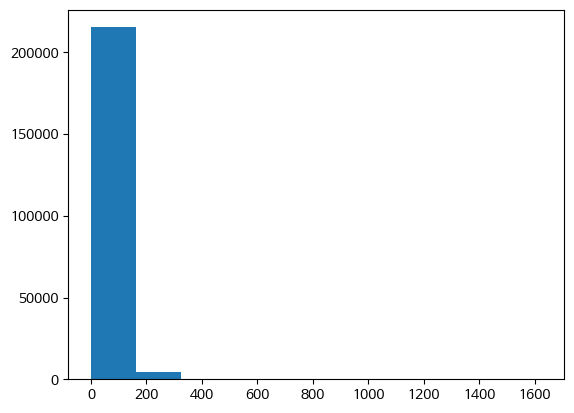

In [ ]:
plt.hist(prediction)
plt.show()

In [ ]:
sample_submission.to_csv("./targetencoding.csv", index=False)